Script to simulate hydrodynamics over a river section based on different discharges upstream.

The physical calculations are performed by the analytical model based on the Manning formula, for which stationar and uniform flow is assumed:

    Q=K S^0,5 A R^(2/3)

To do that first the geometric parameters (hydraulic radius, perimeter and surface area) are computed by the function conv_function_basic() based on the input of a criss section('data_bat_csv).

Since we are not always dealing with normal flow a backwatercurve is performed by the Bresse fit
    d = de + (d0-de)2^(L/105) with L05 - 0.24 de /S*d(d0/de)^0,75
    
By Bart Strijker, adapted by Koen Hiemstra. Koen Hiemstra applied a method for Transverse slope and Bedforms.


Version Frederik:
This is a concept model for PhD-research of the Rhine branches. In this case the river stretch Waal.



In [1]:
#In this cell all the needed packages in this script are imported:

import math
from numpy import *
import matplotlib.pyplot as plt
import csv
from scipy.optimize import fsolve,newton
import networkx as nx

In [2]:
#Physical parameters
g=9.81

## Define the parameters of the river system 

In [3]:
#Bathymetry river system: This is a file based on the data of a SOBEK-simulation in 2013 (provided by Max Schropp to Koen Hiemstra).
with open ('River_branches_data.csv') as f:   #Reading csv file with bathymetry data of the river branches
    reader = csv.reader(f, delimiter=';')
    base_list = list(reader)
    mylist=base_list[1:681]

# Define lists of parameters
    
    point=[]
    name=[]
    x=[]
    y=[]
    kms=[]
    waterlevels=[]
    width_summerbed=[]
    level_summerbed=[]
    level_winterbed=[]
    chezy=[] 

    for row in mylist:
        point.append(row [0])
        name.append(row [1])
        x.append(row[2])
        y.append(row[3])
        kms.append(row[5])
        waterlevels.append(row [9])
        width_summerbed.append(row[11])
        level_summerbed.append(row[21])
        level_winterbed.append(row[24])
        chezy.append(row[27])        

# Change items of list from strings to floating numbers or integer 
location = [int(i) for i in point]
X = [float(i) for i in x] #positie moet nog door 1000 worden gedeeld om oorspronkelijke coordinaten terug te krijgen
Xco = [X[n]/1000 for n in range (0,len(X))]
Y = [float(i) for i in y] #positie moet nog door 1000 worden gedeeld om oorspronkelijke coordinaten terug te krijgen
Yco = [Y[n]/1000 for n in range (0,len(Y))]
KM = [int(i) for i in kms]
Waterlevel = [int(i) for i in waterlevels] #waterlevels in centimeters
Width_summerbed = [int(i) for i in width_summerbed] # width in meter
Level_summerbed = [int(i) for i in level_summerbed] # NAP + centimeters
Level_winterbed = [int(i) for i in level_winterbed] # NAP + centimeters
Chezy = [int(i) for i in chezy]


In [4]:
# Define the different riverstretches of the system
# Bovenrijn = cell 0:8
# Waal = cell 9:195
# Pannerdensch kanaal = cell 196:220
# Nederrijn = cell 221:319
# Lek = cell 320:440
# Yssel = cell 441:669
# Keteldiep = cell 670:679

In [5]:
# A list of the distance along the river between the locations is determined based on the riverlocations and X/Y-coordinates.    
dKM=[KM[n]-KM[n-1] for n in range(1,len(KM))] #distance between the locations
dX=[Xco[n]-Xco[n-1] for n in range(1,len(Xco))]
dY=[Yco[n]-Yco[n-1] for n in range(1,len(Yco))]

#print(dKM)


## Define the hydraulic boundary conditions: incoming river discharge upstream of the river and the downstream water level based on a Q-h relation. 

In [6]:
# This part describes the hydraulic boundary conditions: incoming river discharge upstream of the river and the downstream water level based on a Q-h relation.
# The upstream boundary condition is the incoming riverdischarge at Lobith. At bifurcation Pannerdensche kop a discharge distribution is applied 
# for the discharges into the Waal and the Pannerdensch channel. At the second bifurcation Ysselkop also a discharge distribution to the Nederrijn
# and the Yssel is implemented based on the information provided RWS Oost-Nederland. Information from year 2000 based on measurements 
# of the year 1998 & 1999 for closed barriers in the Nederrijn.

import csv
with open ('DD_Rhinebranches.csv') as f:   #Reading csv file with bathymetry data of the river Waal
    reader = csv.reader(f, delimiter=';')

# Define lists of river discharges
    qlobith=[]
    qwaal=[]
    qpkan=[]
    qneder=[]
    qyssel=[]
    qtotal=[]
        
    for row in reader:    
          
        qlobith.append(row[0]) # incoming discharge Lobith
        qwaal.append(row[1]) # discharge Waal
        qpkan.append(row[2]) # discharge Pannerdensch kanaal
        qneder.append(row[3]) #discharge Nederrijn
        qyssel.append(row[4]) #discharge Yssel

# Change items of list from strings to floating numbers or integer 
Qlob = [int(i) for i in qlobith] 
Qwaal = [int(i) for i in qwaal] 
Qpkan = [int(i) for i in qpkan] 
Qneder = [int(i) for i in qneder] 
Qyssel = [int(i) for i in qyssel]  

#print(Qyssel)    

Qbovenrijn 1013
QPannerdensch Kanaal 200
QWaal 813
QNederrijn 30
QYssel 170


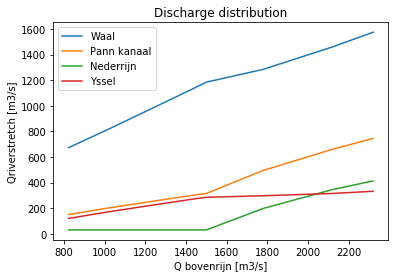

In [7]:
# In this cell the discharge distribution is defined based on the given river discharge of the Bovenrijn.
waal, = plt.plot(Qlob, Qwaal, label='Waal') 
pkan, = plt.plot(Qlob, Qpkan, label='Pann kanaal')               
neder, = plt.plot(Qlob, Qneder, label='Nederrijn') 
yssel, = plt.plot(Qlob, Qyssel, label='Yssel')
plt.title('Discharge distribution')
plt.legend(handles=[waal, pkan, neder, yssel])

plt.ylabel('Qriverstretch [m3/s]')
plt.xlabel('Q bovenrijn [m3/s]')

# River discharge division in case of closed barriers in the range of QLobith=823-1430 m3/s
qbovenrijn=1013

if qbovenrijn==823:
    qpkan=150
    qwaal=673
    qnederrijn=30
    qyssel=120
    bovenrijn_ben=721.8
    pankan_ben=697.8
    waal_ben=69
    neder_ben=271.6
    yssel_ben=-32.5
elif qbovenrijn==1013:
    qpkan=200
    qwaal=813
    qnederrijn=30
    qyssel=170   
else:
    print('No values.')
    
print('Qbovenrijn',qbovenrijn)
print('QPannerdensch Kanaal',qpkan)
print('QWaal',qwaal)
print('QNederrijn',qnederrijn)
print('QYssel',qyssel)

## Manning formula calculations to determine normal and critical flow depth.

In [24]:
#Flip arrays for calculation starting at the downstream location of the riverstretch
Xco_flip=Xco[::-1]
Yco_flip=Yco[::-1]
KM_flip=KM[::-1]
dKM_flip=dKM[::-1]
Waterlevel_flip=Waterlevel[::-1]
Width_summerbed_flip=Width_summerbed[::-1]
Level_summerbed_flip=Level_summerbed[::-1]
Level_winterbed_flip=Level_winterbed[::-1] 
Chezy_flip=Chezy[::-1]

# Define the different riverstretches of the system
# Bovenrijn = cell 671:681 
xbovenrijn = KM_flip[671:681]
dKMbovenrijn = dKM_flip[671:681]
wlbovenrijn = Waterlevel_flip[671:681]
WSbovenrijn = Width_summerbed_flip [671:681]
LSbovenrijn = Level_summerbed_flip[671:681]
LWbovenrijn = Level_winterbed_flip[671:861]

# Waal = cell 484:671
xwaal = KM_flip[484:671]
dKMwaal = dKM_flip[484:671]
wlwaal = Waterlevel_flip[484:671]
WSwaal = Width_summerbed_flip[484:671]
LSwaal = Level_summerbed_flip[484:671]
LWwaal = Level_winterbed_flip[484:671]

# Pannerdensch kanaal = cell 460:484
xpankan = KM_flip[460:484]
dKMpankan = dKM_flip[460:484]
wlpankan = Waterlevel_flip[460:484]
WSpankan = Width_summerbed_flip[460:484]
LSpankan = Level_summerbed_flip[460:484]
LWpankan = Level_winterbed_flip[460:484]

# Nederrijn = cell 360:460
xneder = KM_flip[360:460]
dKMneder = dKM_flip[360:460]
wlneder = Waterlevel_flip[360:460]
WSneder = Width_summerbed_flip[360:460]
LSneder = Level_summerbed_flip[360:460]
LWneder = Level_winterbed_flip[360:460]

# Lek = cell 239:360 
xlek = KM_flip[239:360]
dKMlek = dKM_flip[239:360]
wllek = Waterlevel_flip[239:360]
WSlek = Width_summerbed_flip[239:360]
LSlek = Level_summerbed_flip[239:360]
LWlek = Level_winterbed_flip[239:360]

# Yssel = cell 10:239
xyssel = KM_flip[10:239]
dKMyssel = dKM_flip[10:239]
wlyssel = Waterlevel_flip[10:239]
WSyssel = Width_summerbed_flip[10:239]
LSyssel = Level_summerbed_flip[10:239]
LWyssel = Level_winterbed_flip[10:239]

# Keteldiep = cell 670:679



In [25]:
print(len(xyssel))

229


In [26]:
#Channel slope
#According to De Vries (1993), Sieben (2009), Sloff et al.(2014) and Blom (2016), the channel slope of the Waal river is 1.0*10^-4
#and 1.2*10^-4.

S0=0.00012 #bed slope of the rivert
k=1 #roughnesse dependend on discharge
n=0.0295 #Roughness of main channel
C0=1

#Riverstretch Bovenrijn

#normal flow
def Manning (y, qbovenrijn, b, S, n, k, m):
    A=(b+m*y)*y # conveyance surface area [m2] =>(width*depth)
    R=A/(b+2*y*(1+m**2)**(1/2)) #hydraulic radius [-]
    return qbovenrijn-(C0/n)*A*R**(2/3)*S**(1/2)
m=0

y0_br = zeros(len(WSbovenrijn))
y0_br = [fsolve(Manning,1, args=(qbovenrijn, WSbovenrijn[i], S0, n, C0, m)) for i in range (0, len(WSbovenrijn))] #normal flow depth in steady flow
# is also upstream water dept of river stretch  

waterlevels_normalbovenrijn =zeros(len(y0_br))
waterlevels_normalbovenrijn = [y0_br[i]*100+LSbovenrijn[i] for i in range(0, len(y0_br))] #bovenstroomse waterstand van een traject dx tov NAP [m]=h_bov_e

Text(0.5,0,'distance, x [m]')

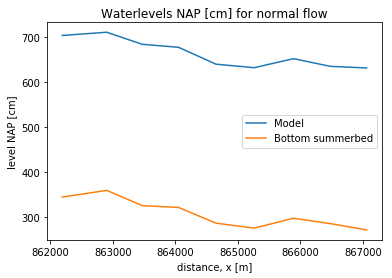

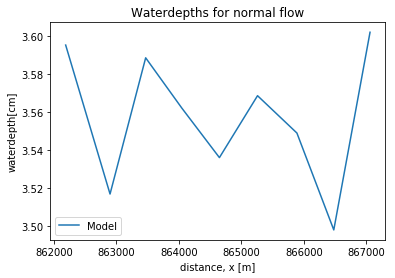

In [40]:
#This cell is added to plot figures based on the determined variables.
plt.figure(1)
model, =plt.plot(xbovenrijn, waterlevels_normalbovenrijn, label='Model')
bottom, = plt.plot(xbovenrijn, LSbovenrijn, label='Bottom summerbed')
plt.title('Waterlevels NAP [cm] for normal flow')
plt.legend(handles=[model, bottom])
plt.ylabel('level NAP [cm]')
plt.xlabel('distance, x [m]')

plt.figure(2)
model, =plt.plot(xbovenrijn, y0_br, label='Model')
plt.title('Waterdepths for normal flow')
plt.legend(handles=[model])
plt.ylabel('waterdepth[cm]')
plt.xlabel('distance, x [m]')


In [28]:
#Channel slope
#According to De Vries (1993), Sieben (2009), Sloff et al.(2014) and Blom (2016), the channel slope of the Waal river is 1.0*10^-4
#and 1.2*10^-4.

S0=0.00012 #bed slope of the rivert
k=1 #roughnesse dependend on discharge
n=0.03 #Roughness of main channel
C0=1

#Riverstretch Waal & Yssel

#normal flow
def Manning (y, qwaal, b, S, n, k, m):
    A=(b+m*y)*y # conveyance surface area [m2] =>(width*depth)
    R=A/(b+2*y*(1+m**2)**(1/2)) #hydraulic radius [-]
    return qwaal-(C0/n)*A*R**(2/3)*S**(1/2)
m=0

#normal flow
def Manning (y, qyssel, b, S, n, k, m):
    A=(b+m*y)*y # conveyance surface area [m2] =>(width*depth)
    R=A/(b+2*y*(1+m**2)**(1/2)) #hydraulic radius [-]
    return qwaal-(C0/n)*A*R**(2/3)*S**(1/2)
m=0

#normal flow depth in steady flow is also upstream water dept of river stretch  
y0_waal = zeros(len(WSwaal))
y0_yssel = zeros(len(WSyssel))

y0_waal = [fsolve(Manning,1, args=(qwaal, WSwaal[i], S0, n, C0, m)) for i in range (0, len(WSwaal))] 
y0_yssel = [fsolve(Manning,1, args=(qyssel, WSyssel[i], S0, n, C0, m)) for i in range (0, len(WSyssel))] 

#bovenstroomse waterstand van een traject dx tov NAP [m]=h_bov_e
waterlevels_normalwaal =zeros(len(y0_waal))
waterlevels_normalyssel =zeros(len(y0_waal))

waterlevels_normalwaal = [y0_waal[i]*100+LSwaal[i] for i in range(0, len(y0_waal))] 
waterlevels_normalyssel = [y0_yssel[i]*100+LSyssel[i] for i in range(0, len(y0_yssel))] 

In [ ]:
#print(waterlevels_normalwaal)

Text(0.5,0,'distance, x [m]')

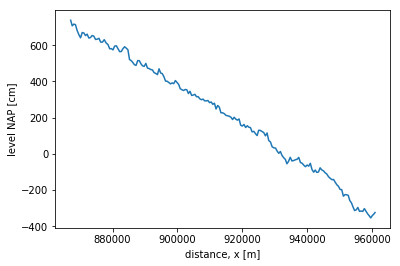

In [29]:
#This cell is added to plot figures based on the determined variables.
plt.plot(xwaal, waterlevels_normalwaal)
plt.ylabel('level NAP [cm]')
plt.xlabel('distance, x [m]')

Text(0.5,0,'distance, x [m]')

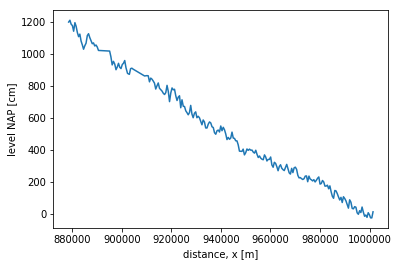

In [14]:
#This cell is added to plot figures based on the determined variables.
plt.plot(xyssel, waterlevels_normalyssel)
plt.ylabel('level NAP [cm]')
plt.xlabel('distance, x [m]')

## Bresse equation

Based on the Bresse equation the backwatercurve based on the downstream water level can be determined.

In [15]:
# Riverstretch Bovenrijn
C=48 #chezy-coefficient

qbr = [qbovenrijn/WSbovenrijn[n] for n in range (0, len(dKMbovenrijn))] #discharge per unit width for each river stretch
#cor_q=[round(q[n],2) for n in range (0,len(dKMbovenrijn))]

h_eq_br = [(qbr[n]**2/((C**2)*S0))**(1/3)for n in range (0, len(dKMbovenrijn))] #equilibrium water depthfor each river stretch
#cor_h_eq=[round(h_eq[n],2) for n in range (0,len(dKMbovenrijn))]

#L_05 = [(0.24*cor_h_eq[n]/S0)*(y0[n]/cor_h_eq[n])**(4/3)for n in range (0, len(dKMbovenrijn))] #half length for each river stretch
L_05_normal_br = [(0.24*y0_br[n]/S0)*(y0_br[n-1]/y0_br[n])**(4/3)for n in range (0, len(dKMbovenrijn))] #half length for each river stretch

dd0_bovenrijn = [waterlevels_normalbovenrijn[i+1]-waterlevels_normalbovenrijn[i]+dKMbovenrijn[i]*S0 for i in range(0, len(dKMbovenrijn))] #bodemligging

In [16]:
# Riverstrech Bovenrijn

hflip_bovenrijn = zeros(len(dKMbovenrijn))


for i in range (0,7):
    hflip_bovenrijn[0]=721.8
         
    hflip_bovenrijn[i+1] = waterlevels_normalbovenrijn[i] + (hflip_bovenrijn[i]-waterlevels_normalbovenrijn[i]+S0*dKMbovenrijn[i])*(1/2)**(dKMbovenrijn[i]/L_05_normal_br[i])#water level at location x+1
    
    waterlevels_bovenrijn=hflip_bovenrijn[::-1]
    
    diff = zeros(len(waterlevels_bovenrijn))
    diff = [waterlevels_bovenrijn[i]-wlbovenrijn[i] for i in range(0,8)]

In [17]:
print(len(waterlevels_normalbovenrijn))

9


Text(0.5,0,'distance [m]')

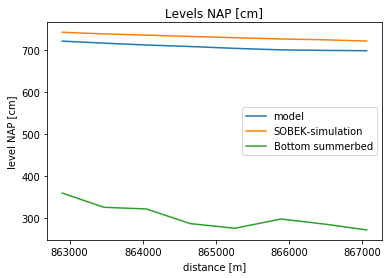

In [18]:
# Plot of riverstretch Bovenrijn
model, = plt.plot(xbovenrijn[0:8], waterlevels_bovenrijn[0:8], label='model') 
SOBEK, = plt.plot(xbovenrijn[0:8], wlbovenrijn[0:8], label='SOBEK-simulation')
bottom, = plt.plot(xbovenrijn[0:8], LSbovenrijn[0:8], label='Bottom summerbed')
plt.title('Levels NAP [cm]')
plt.legend(handles=[model, SOBEK, bottom])
plt.ylabel('level NAP [cm]')
plt.xlabel('distance [m]')

In [19]:
# Riverstretch Waal and Yssel
Cwaal=42 #chezy-coefficient
Cyssel=30

#discharge per unit width for each river stretch
qw = [qwaal/WSwaal[n] for n in range (0, len(dKMwaal))] 
qy = [qyssel/WSyssel[n] for n in range (0, len(dKMyssel))] 
#equilibrium water depthfor each river stretch
h_eq_waal = [(qw[n]**2/((Cwaal**2)*S0))**(1/3)for n in range (0, len(dKMwaal))]
h_eq_yssel = [(qy[n]**2/((Cyssel**2)*S0))**(1/3)for n in range (0, len(dKMyssel))] 
#L_05 = [(0.24*cor_h_eq[n]/S0)*(y0[n]/cor_h_eq[n])**(4/3)for n in range (0, len(dKMwaal))] #half length for each river stretch

#half length for each river stretch
L_05_normal_waal = [(0.24*y0_waal[n]/S0)*(y0_waal[n-1]/y0_waal[n])**(4/3)for n in range (0, len(dKMwaal))]
L_05_normal_yssel = [(0.24*y0_yssel[n]/S0)*(y0_yssel[n-1]/y0_yssel[n])**(4/3)for n in range (0, len(dKMyssel))]

#bodemligging
dd0_waal = [waterlevels_normalwaal[i+1]-waterlevels_normalwaal[i]+dKMwaal[i]*S0 for i in range(0,185)] 
dd0_yssel = [waterlevels_normalyssel[i+1]-waterlevels_normalyssel[i]+dKMyssel[i]*S0 for i in range(0,185)] 


In [20]:
# Riverstretch Waal and Yssel

hflip_waal = zeros(len(dKMwaal))

#d0_waal = zeros(len(LSwaal))

for i in range (0,185):
    hflip_waal[0]=69
    #d0[0]=wl_flip[0]-bl_sum_flip[0]
      
    hflip_waal[i+1] = waterlevels_normalwaal[i] + (hflip_waal[i]-waterlevels_normalwaal[i]+S0*dKMwaal[i])*(1/2)**(dKMwaal[i]/L_05_normal_waal[i])#water level at location x+1
    
    waterlevels_waal=hflip_waal#[::-1]
    
    diff_waal = zeros(len(waterlevels_waal))
    diff_waal = [waterlevels_waal[i]-wlwaal[i] for i in range(0,185)]


    #hflip[i+1] = dflip[i] + cor_bl_sum[i]
    #h_wl = hflip[::-1]
    #d0[i+1]=dx_flip[i]*S#d0[i]+

    #dflip[i+1] = y0[i] + (dflip[i]-y0[i])*(1/2)**(dx_flip[i]/L_05_normal[i])#depth at location x+1
    #dd0[i] = [waterlevels_normal[i]-waterlevels[i-1]+dx_flip[i]*S 
    
    #hflip[i+1] = waterlevels_normal[i+1] + (dd0[i]*2)**(dx_flip[i]/L_05_normal[i])#water level at location x+1
    


In [21]:
print(average(diff_waal))

-159.0759785475994


Text(0.5,0,'distance [m]')

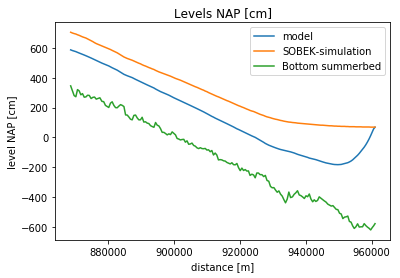

In [22]:
# Plot of riverstretch Waal
model, = plt.plot(xwaal[0:184], waterlevels_waal[0:184], label='model') 
SOBEK, = plt.plot(xwaal[0:184], wlwaal[0:184], label='SOBEK-simulation')
bottom, = plt.plot(xwaal[0:184], LSwaal[0:184], label='Bottom summerbed')
plt.title('Levels NAP [cm]')
plt.legend(handles=[model, SOBEK, bottom])
plt.ylabel('level NAP [cm]')
plt.xlabel('distance [m]')

In [23]:
hflip_yssel = zeros(len(dKMyssel))
for i in range (0,228):
    hflip_yssel[0]=-32.5
    #d0[0]=wl_flip[0]-bl_sum_flip[0]
      
    hflip_yssel[i+1] = waterlevels_normalyssel[i] + (hflip_yssel[i]-waterlevels_normalyssel[i]+S0*dKMyssel[i])*(1/2)**(dKMyssel[i]/L_05_normal_yssel[i])#water level at location x+1
    
    waterlevels_yssel=hflip_yssel#[::-1]
    
    diff_yssel = zeros(len(waterlevels_yssel))
    diff_yssel = [waterlevels_yssel[i]-wlyssel[i] for i in range(0,228)]


Text(0.5,0,'distance, x [m]')

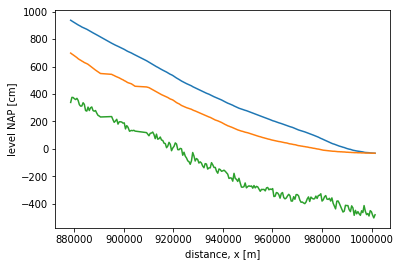

In [54]:
# Plot of riverstretch Yssel
plt.plot(xyssel, waterlevels_yssel, xyssel, wlyssel, xyssel, LSyssel)
plt.ylabel('level NAP [cm]')
plt.xlabel('distance, x [m]')

## Plotting the graph as applied in the SOBEK-schematisation in 2013.

In [22]:
import networkx as nx

# Definition of the nodes in the graph. The nodes in the graph are the locations of calculation points of the SOBEK-simulation.
G = nx.Graph()
G.add_node(location[0], pos=(X[0],Y[0]), name=(KM[0]))
#G.add_nodes_from(location[:], pos=(X[:],Y[:]), name=(KM[:]))

for i in enumerate(location()): #adds nodes with label 1 till n nodes to the network. 
    G.add_node(i, pos= (X[i],Y[i])
    #lat_lon_to_index[node] = i

#print(G.node[7])

# Definition of the edges between the nodes. The edges are defined by the different riverstreches given in the previous cell (definition of riverstretches). 
#def calculate_distance(Node1, Node2):
    # calculate distance between two points
   # distance = float(((Node2[0]-Node1[0])**2+(Node2[1]-Node1[1])**2)**0.5)
   # return float(distance)



#G.add_edge(location[0],location[1], dis= calculate_distance(nx.get_node_attributes(G, 'pos')[location[0]], nx.get_node_attributes(G, 'pos')[location[0]]))
 #for edge in G.edges(data=True): 
#G.add_edge(location[edge[0]], location[edge[1]], dis= calculate_distance(nx.get_node_attributes(G, 'pos')[location[edge[1]]], nx.get_node_attributes(G, 'pos')[location[edge[0]]]))   

    
#import matplotlib.pyplot as plt
#plt.figure(figsize=(18,18))
#nx.draw(G, nx.get_node_attributes(G, 'name'))


#nx.draw(w_G, nx.get_node_attributes(w_G, 'pos'), with_labels=True, node_size=0.5, font_size = 8)


SyntaxError: unexpected EOF while parsing (<ipython-input-22-39280ac6abc6>, line 32)

## Plotting figures of results

In [23]:
#This cell is added to plot figures based on the determined variables.

#import matplotlib.pyplot as plt

plt.plot(x,cor_bl_sum, x, cor_bl_win)
plt.ylabel('level NAP [m]')
plt.xlabel('distance, x [m]')

NameError: name 'cor_bl_sum' is not defined

In [24]:
import matplotlib.pyplot as plt

plt.plot(x,cor_bl_sum,x_flip, waterlevels_normal)
plt.ylabel('normal depth, y [m]')
plt.xlabel('distance, x [m]')
plt.title('waterlevel for normal flow in river stretch')

NameError: name 'cor_bl_sum' is not defined

In [25]:
#Cell added to print and plot.
print(waterlevels)

#import matplotlib.pyplot as plt

plt.plot(x[0:91], hflip[0:91], x[0:91],bl_sum_flip[0:91])
plt.ylabel('water level,[NAP+m]')
plt.xlabel('distance, x [m]')

['747', '743', '739', '736', '733', '730', '727', '725', '722', '722', '717', '712', '706', '701', '697', '694', '689', '685', '680', '675', '671', '667', '661', '655', '649', '643', '636', '630', '626', '620', '614', '609', '605', '600', '595', '590', '584', '578', '573', '568', '562', '554', '547', '540', '535', '530', '526', '522', '518', '513', '508', '503', '498', '494', '488', '483', '479', '474', '469', '465', '460', '456', '450', '445', '440', '435', '431', '427', '423', '419', '415', '411', '406', '401', '396', '392', '388', '384', '379', '374', '369', '364', '360', '355', '350', '345', '340', '336', '331', '326', '321', '317', '311', '307', '301', '296', '291', '286', '281', '276', '272', '272', '267', '262', '257', '252', '247', '243', '238', '233', '228', '223', '218', '213', '209', '204', '200', '195', '190', '186', '181', '177', '174', '170', '165', '160', '155', '151', '147', '142', '138', '135', '132', '128', '125', '122', '120', '117', '114', '112', '109', '107', '105'

NameError: name 'hflip' is not defined

In [26]:
#Write output to a CSV-file
import csv

with open('employee_file.csv', mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    employee_writer.writerow([Xco_flip])
    #employee_writer.writerow(['Erica Meyers', 'IT', 'March'])

#with open(test, "w") as f:
    #writer = csv.writer(f)
    #for row in rows:
       # writer.writerow(row)

In [27]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('model.xlsx')
worksheet = workbook.add_worksheet()

# Some data we want to write to the worksheet.
expenses = xbovenrijn
    #['Rent', 1000],
    #['Gas',   100],
    #['Food',  300],
    #['Gym',    50],
#)

# Start from the first cell. Rows and columns are zero indexed.
row = 0
col = 0

# Iterate over the data and write it out row by row.
#for item, cost in (expenses):
    worksheet.write(row, col,     expenses)
    #worksheet.write(row, col + 1, cost)
    #row += 1

# Write a total using a formula.
#worksheet.write(row, 0, 'Total')
#worksheet.write(row, 1, '=SUM(B1:B4)')

workbook.close()

IndentationError: unexpected indent (<ipython-input-27-5fb3792f5b8b>, line 21)